In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SKS\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/SKS/Desktop/AAIC/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
final=final.iloc[:100000,:]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2519.87it/s]


In [24]:
preprocessed_reviews[276]

''

# [4] Featurization

## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer( min_df=10,max_features=2000)
tfidf=tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'across', 'active', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 2000)
the number of unique words including both unigrams and bigrams  2000


### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [27]:
top_features =tf_idf_vect.get_feature_names()

In [28]:
len(top_features)

2000

### Verifying  Co_Occurrence Matrix

In [29]:
corpus=["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]

top_words=["abc", "pqr", "def"]

In [30]:
'''

###### BRUTE FORCE ALGORITHM FOR WINDOW=2 ######

import numpy as np
import pandas as pd
matrix=np.zeros((len(top_words),len(top_words)))
co_occurence_df=pd.DataFrame(matrix,index=top_words,columns=top_words)
for i in corpus:
    words=i.split(" ")
    for j,word in enumerate(words):
        if word in top_words:
            if j==0:
                if len(words)<3:
                    for k in range(2):
                        if words[k] in top_words:                          
                            co_occurence_df.loc[word,words[k]]+=1                            
                else:
                    for k in range(3):
                        if words[k] in top_words:                            
                            co_occurence_df.loc[word,words[k]]+=1                            
            elif j==1:
                if len(words)<4:
                    for k in range(j-1,j+2):
                        if words[k] in top_words:                            
                            co_occurence_df.loc[words[j],words[k]]+=1                           
                else:
                    for k in range(j-1,j+3):
                        if words[k] in top_words:                            
                            co_occurence_df.loc[words[j],words[k]]+=1                                        
            elif j==len(words)-1:
                for k in range(j-2,j+1):
                        if words[k] in top_words:                            
                            co_occurence_df.loc[words[j],words[k]]+=1                                        
            elif j==len(words)-2:
                for k in range(j-2,j+2):
                        if words[k] in top_words:                            
                            co_occurence_df.loc[words[j],words[k]]+=1                                            
            elif j>1:
                for k in range(j-2,j+3):
                    if words[k] in top_words:                        
                        co_occurence_df.loc[words[j],words[k]]+=1
'''                      

'\n\n###### BRUTE FORCE ALGORITHM FOR WINDOW=2 ######\n\nimport numpy as np\nimport pandas as pd\nmatrix=np.zeros((len(top_words),len(top_words)))\nco_occurence_df=pd.DataFrame(matrix,index=top_words,columns=top_words)\nfor i in corpus:\n    words=i.split(" ")\n    for j,word in enumerate(words):\n        if word in top_words:\n            if j==0:\n                if len(words)<3:\n                    for k in range(2):\n                        if words[k] in top_words:                          \n                            co_occurence_df.loc[word,words[k]]+=1                            \n                else:\n                    for k in range(3):\n                        if words[k] in top_words:                            \n                            co_occurence_df.loc[word,words[k]]+=1                            \n            elif j==1:\n                if len(words)<4:\n                    for k in range(j-1,j+2):\n                        if words[k] in top_words:            

In [37]:
import numpy as np
import pandas as pd
def create_co_occurrence(data,window,features):
    matrix=np.zeros((len(features),len(features)))
    co_occurence_df=pd.DataFrame(matrix,index=features,columns=features)
    for i in tqdm(data):
        words=i.split(" ")
        size=len(words)-1
        if len(words)>window:
            for j,word in enumerate(words):
                if word in features:
                    for k in range(max(j-window,0),min(j+window,size)+1):
                        if words[k] in features:
                            co_occurence_df.loc[word,words[k]]+=1
    return co_occurence_df

In [38]:
co_occurrence_df=create_co_occurrence(corpus,2,top_words)
co_occurrence_df

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 334.26it/s]


,abc,pqr,def
abc,3.0,3.0,3.0
pqr,3.0,4.0,2.0
def,3.0,2.0,2.0


### [5.2] Calulation of Co-occurrence matrix with context_window=2

In [39]:
if os.path.isfile('co_occurence_df.csv'):
    co_occurence_df=pd.DataFrame.from_csv('co_occurence_df.csv',index_col=0)
else:
    co_occurrence_df=create_co_occurrence(preprocessed_reviews,2,top_features)
    co_occurence_df.to_csv('co_occurence_df.csv')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:04:47<00:00, 25.72it/s]


In [40]:
co_occurence_df.astype(bool).sum(axis=0)

able          1391
absolute       482
absolutely    1338
according      564
acid           465
across         759
active         381
actual         673
actually      1685
add           1667
added         1437
addicted       623
addictive      566
adding        1089
addition       999
additional     588
additives      403
adds           737
admit          563
adult          486
advertised     553
affordable     461
afraid         449
afternoon      561
aftertaste     718
agave          502
age            509
ago           1215
agree          684
ahead          458
              ... 
works         1318
world         1027
worried        531
worry          668
worse          632
worst          674
worth         1418
would         1984
wow            759
wrap           443
wrapped        621
write          462
wrong         1023
xylitol        390
yard           395
yeah           465
year          1433
years         1706
yeast          693
yellow         627
yes           1204
yesterday   

### [5.3] Finding optimal value for number of components (n) to be retained.

In [41]:
# Please write all the code with proper documentation
import scipy
co_occurence_matrix=scipy.sparse.csr_matrix(co_occurence_df.values)
co_occurence_matrix.shape


(2000, 2000)

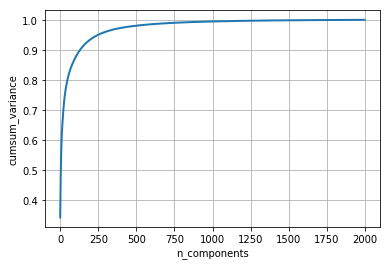

In [42]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD()
svd.n_components=1999
svd.fit_transform(co_occurence_matrix)
percentage_var_explained=svd.explained_variance_/np.sum(svd.explained_variance_)
cum_sum_var=np.cumsum(percentage_var_explained)
plt.figure(1,figsize=(6,4))
plt.plot(cum_sum_var,linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('cumsum_variance')
plt.show()

#### Here we can see that 500 components explains the variance of approx 95% so we choose 500 components for SVD

In [43]:
svd.n_components=500
svd_data=svd.fit_transform(co_occurence_matrix)
svd_data.shape

(2000, 500)

### [5.4] Applying k-means clustering

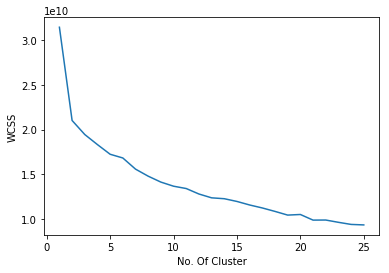

In [44]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
wcss=[]
for i in (range(1,26)):
    kmeans=KMeans(n_clusters=i,random_state=0)
    kmeans.fit(svd_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,26),wcss)
plt.xlabel('No. Of Cluster')
plt.ylabel('WCSS')
plt.show()  

#### As the plot b/w no. of cluster and within cluster sum square distance suddenly changes at 3 so we take no. of cluster=3

In [45]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=3,random_state=0)
kmeans.fit(svd_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [46]:
d={'words':top_features,'Label':kmeans.labels_}
df=pd.DataFrame(data=d)
df.groupby(['Label']).count()


,words
Label,
0,10
1,1
2,1989


#### As we have used very few features so most of the features are goint to 1 cluster 

### [5.5] Wordclouds of clusters obtained in the above section

In [47]:
# Please write all the code with proper documentation
from nltk.tokenize import word_tokenize
# Function to plot word_cloud for given cluster 
def word_cloud_cluster(cluster): 
    words=''
    df_cluster=df[df['Label']==cluster]['words']
    for i in df_cluster:
        words=words+i
        words=words+' '
    from wordcloud import WordCloud
    wordcloud = WordCloud(width = 1500, height = 1500, background_color ='white', min_font_size = 10,stopwords=['']).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8)) 
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title("Cluster {}".format(cluster))
    plt.show() 

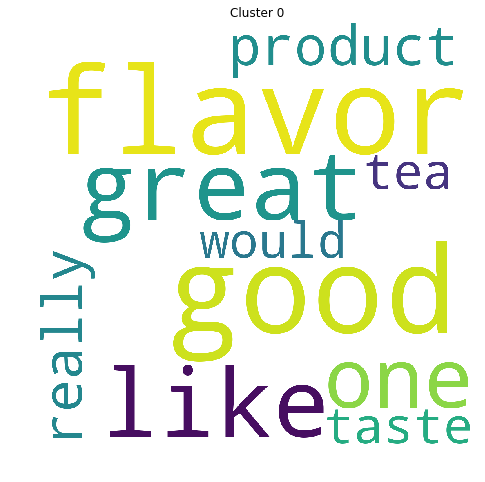

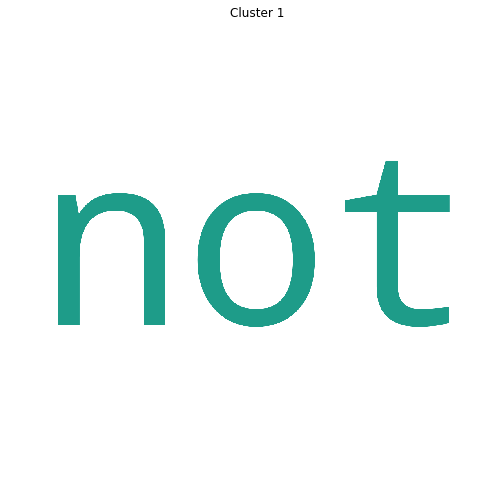

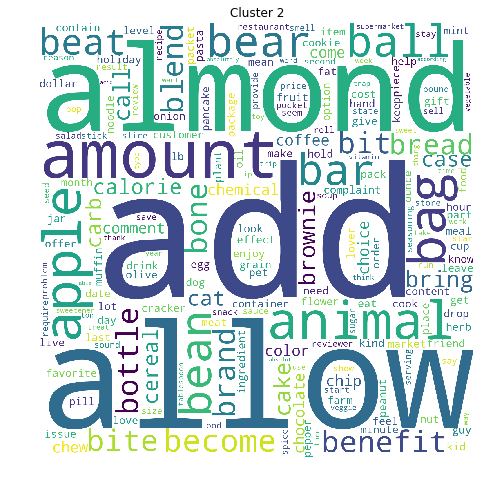

In [48]:
for i in range(3):
    word_cloud_cluster(i)

### [5.6] Function that returns most similar words for a given word.

In [49]:
# Please write all the code with proper documentation
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
similarity_matrix=cosine_similarity(svd_data)
similarity_df=pd.DataFrame(similarity_matrix,index=top_features,columns=top_features)

In [51]:
def most_similar_words(word,number_of_similar_words):
    words=similarity_df.loc[word,:].sort_values(ascending=False).index[1:number_of_similar_words+1]
    for i in words:
        print(i)

In [52]:
top_features[7]

'actual'

In [53]:
most_similar_words(top_features[7],10)

typical
clearly
apparently
downside
supposed
produced
okay
nor
therefore
solid


# [6] Conclusions

In [54]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.
# Please compare all your models using Prettytable library. 


#### As we are using very few features for SVD our clustering is not that good as it is clustering most of the words to single cluster
#### Optimal No. Of Components is 500 after HyperTuning from which we are getting 95% of variance of data
#### We got 3 as the Optimal No. of Cluster